# Spectrum visualisation

Visualising how received spectra vary as a function of endmember proportion. Implemented for three key endmembers (algae, coral, sand) since proportions of additional classes cannot be varied in 2D! 

The spectra are modelled using the AOP Group 1 functions for $bb$ and $K$, using the Lee et al. (1994) shallow-water model. See documentation for more details.


- *Left, triangular slider*: adjust the relative proportion of each endmember.

- *Bottom, upper slider*: adjust the range of wavelengths being plotted.

- *Bottom, lower slider*: adjust the depth of water through which the spectrum travels. 



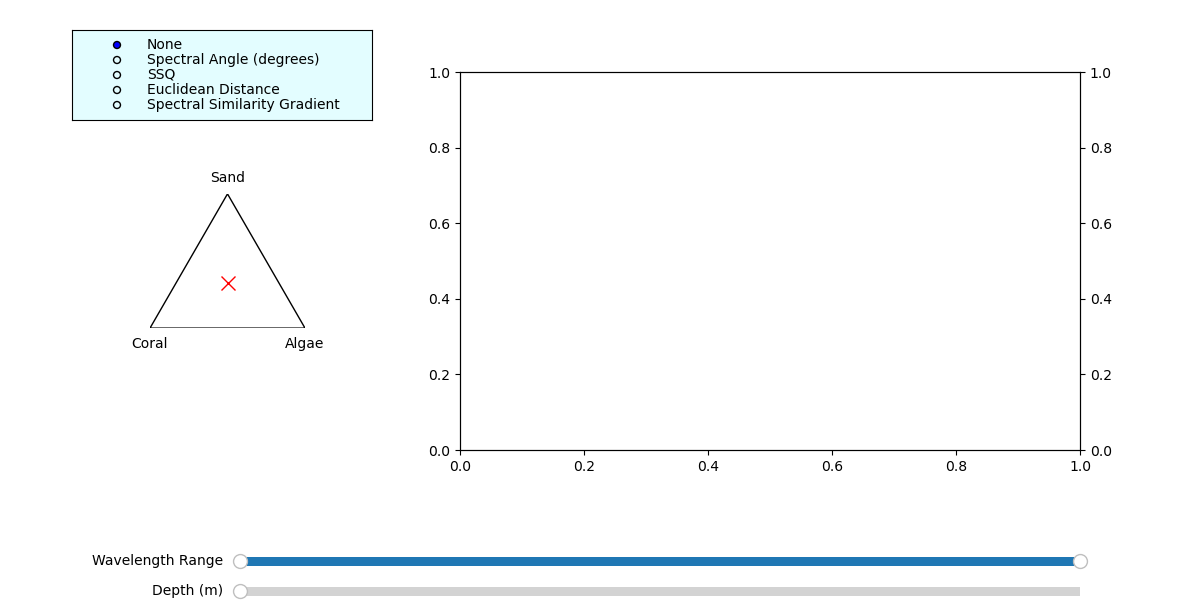

In [3]:
# display interactively
%matplotlib widget

# general
import numpy as np

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider, RangeSlider, RadioButtons
from matplotlib.path import Path as pPath

# custom
from reflectance import file_ops, spectrum_utils

# Load fractional spectra
# TODO: check if not exist, create if necessary
frac_spectra = np.load(file_ops.TMP_DIR_FP / "fractional_spectra.npy")
wvs = np.load(file_ops.TMP_DIR_FP / "wavelengths.npy")
fracs = np.load(file_ops.TMP_DIR_FP / "fracs.npy")

# Define the vertices of the triangle (100% coral, algae, sand)
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

MAX_DEPTH = 10  # maximum depth in meters
COLOURS = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])   # Define the colours for the three components

def get_proportions(point: tuple[float, float], triangle: tuple[tuple[float, float]]):
    """Calculate barycentric coordinates (https://mathworld.wolfram.com/BarycentricCoordinates.html)
    of a point within a triangle."""

    def area(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float]):
        """Calculate area of triangle given 3 points."""
        return 0.5 * abs(
            p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
        )

    total_area = area(*triangle)
    coral_prop = area(point, triangle[1], triangle[2]) / total_area
    algae_prop = area(point, triangle[2], triangle[0]) / total_area
    sand_prop = area(point, triangle[0], triangle[1]) / total_area

    return coral_prop, algae_prop, sand_prop

def closest_point_in_triangle(
    point: tuple[float, float], triangle: tuple[tuple[float, float]]
):
    """In the event that the point is outside the triangle, find the closest point on the triangle."""
    path = pPath(triangle)
    if path.contains_point(point):
        return point
    else:
        # project point onto the nearest edge of the triangle
        min_distance = float("inf")
        closest_point = None  # store closest point
        for i in range(3):  # iterate over triangle edges
            v0, v1 = triangle[i], triangle[(i + 1) % 3]  # get vertices
            projection = np.dot(point - v0, v1 - v0) / np.linalg.norm(v1 - v0) ** 2
            projection = np.clip(projection, 0, 1)
            proj_point = v0 + projection * (v1 - v0)
            distance_to_proj = np.linalg.norm(point - proj_point)
            # check that this is the closest point to any of the sides yet
            if distance_to_proj < min_distance:
                min_distance = distance_to_proj
                closest_point = proj_point
        return closest_point

def on_drag(event: matplotlib.backend_bases.MouseEvent):
    """
    Handle mouse drag event to update the position of a point within a triangle and
    display the corresponding proportions of coral, algae, and sand.

    Parameters:
    event (matplotlib.backend_bases.MouseEvent): The mouse event containing information
    about the drag action, including the new coordinates of the point.

    Returns:
    None
    """
    """Handle mouse drag event."""
    global point_x, point_y  # store coordinates of point being dragged globally
    if event.inaxes == ax:  # if outside axes, do nothing
        new_point_x, new_point_y = event.xdata, event.ydata
        new_point = np.array([new_point_x, new_point_y])
        # constrain point to within triangle
        constrained_point = closest_point_in_triangle(new_point, triangle)
        point_x, point_y = constrained_point
        point.set_data([point_x], [point_y])
        coral_prop, algae_prop, sand_prop = get_proportions(
            [point_x, point_y], triangle
        )
        update_spectrum_with_metric(slider_depth.val)


def update_spectrum_with_metric(val):
    """Update the spectrum and metric plot based on slider and metric values."""
    # initialize twin axis for the difference plot
    depth = slider_depth.val
    depth = np.clip(depth, 0, frac_spectra.shape[3] - 1)    # make sure the depth index is within bounds (overkill)
    depths = np.linspace(0, MAX_DEPTH, frac_spectra.shape[3])

    # find the closest spectrum for the given proportion
    coral_prop, algae_prop, sand_prop = get_proportions([point_x, point_y], triangle)
    coral_index = np.argmin(np.abs(fracs - coral_prop))
    algae_index = np.argmin(np.abs(fracs - algae_prop))
    sand_index = np.argmin(np.abs(fracs - sand_prop))

    # get surface and depth spectra
    surface_spectrum = frac_spectra[coral_index, algae_index, sand_index, 0]
    depth_spectrum = frac_spectra[coral_index, algae_index, sand_index, int(depth)]

    # get wavelength range from slider
    wavelength_range = slider_wavelength.val
    lower_bound, upper_bound = int(wavelength_range[0]), int(wavelength_range[1])
    surface_spectrum = surface_spectrum[lower_bound:upper_bound]
    depth_spectrum = depth_spectrum[lower_bound:upper_bound]
    current_wvs = wvs[lower_bound:upper_bound]

    # clear plots
    ax_spectrum.clear()
    ax_diff.clear()

    # visually compare spectra at different depths
    spectrum_colour = np.clip(
        np.dot((coral_prop, algae_prop, sand_prop), COLOURS), 0, 1
    )
    surface_line = ax_spectrum.plot(current_wvs, surface_spectrum, color=spectrum_colour, label='Surface')
    depth_line = ax_spectrum.plot(current_wvs, depth_spectrum, color=spectrum_colour, ls=":", label=f'Depth: {depths[depth]:.2f}m')
    ax_spectrum.set_xlabel("Wavelength (nm)")   # formatting
    ax_spectrum.set_ylabel("Reflectance", labelpad=10)
    ax_spectrum.set_xlim(min(current_wvs), max(current_wvs))
    ax_spectrum.set_ylim(0, 0.25)
    ax_spectrum.set_title(
        f"Nearest Spectrum: Coral {coral_prop:.2f}, Algae {algae_prop:.2f}, Sand {sand_prop:.1f}",
        pad=10,
    )
    legend_handle = [surface_line[0], depth_line[0]]
    
    if not radio_metrics.value_selected == "None":
        # calculate and plot the difference using the selected metric
        selected_metric = radio_metrics.value_selected
        metric_diff = metrics["functions"][selected_metric](surface_spectrum, depth_spectrum)
        if selected_metric == "Spectral Angle (degrees)":
            metric_diff = np.degrees(metric_diff)
        diff_line = ax_diff.plot(current_wvs, np.repeat(metric_diff, len(current_wvs)), color='k', ls="--", label=f'$\\Delta$ = {metric_diff:.3f}' + "$^\\circ$" if selected_metric == "Spectral Angle (degrees)" else f'$\\Delta$ = {metric_diff:.3f}')
        ax_diff.yaxis.set_label_position("right")  # formatting
        ax_diff.set_ylabel(f"$\\Delta$ {selected_metric}", labelpad=10)
        ax_diff.set_ylim(metrics["ranges"][selected_metric])
        legend_handle = legend_handle + [diff_line[0]]
    else:   # remove ticks on the right-hand side if no metric is selected
        ax_diff.set_yticks([])
        
    ax_spectrum.legend(handles=legend_handle, loc='upper right')
    fig.canvas.draw_idle()

fig, (ax, ax_spectrum) = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[1, 4])
# triangle plot
ax.set_aspect("equal")
ax.axis('off')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5 * np.tan(np.pi / 3))
ax.add_patch(Polygon(triangle, closed=True, fill=None, edgecolor="black"))
point_x, point_y = 0.5, np.sqrt(3) / 6
(point,) = ax.plot([point_x], [point_y], "rx", markersize=10)

for (x, y), label in zip(triangle, ["Coral", "Algae", "Sand"]): # label triangle vertices
    ax.text(x, y - 0.1 if y == 0 else y + 0.1, label, ha="center", va="center")

# define metrics functions
metrics = {
    "functions": {
        "None": None,
        "Spectral Angle (degrees)": spectrum_utils.spectral_angle,
        "SSQ": spectrum_utils.calc_ssq,
        "Euclidean Distance": spectrum_utils.calc_euclidean_distance,
        "Spectral Similarity Gradient": spectrum_utils.calc_spectral_similarity_gradient,
    },
    "ranges": {
        "Spectral Angle (degrees)": (0, 180),
        "SSQ": (0, 1),
        "Euclidean Distance": (0, 1),
        "Spectral Similarity Gradient": (0, 1),
    },
}
ax_radio_metrics = plt.axes([0.06, 0.8, 0.25, 0.15], facecolor="#e3fdff")
radio_metrics = RadioButtons(ax_radio_metrics, list(metrics["functions"].keys()), active=0)

slider_depth = Slider(plt.axes([0.2, 0, 0.7, 0.03]), "Depth (m)", 0, frac_spectra.shape[3] - 1, valinit=0, valstep=1)
slider_wavelength = RangeSlider(plt.axes([0.2, 0.05, 0.7, 0.03]), "Wavelength Range", 0, wvs.shape[0] - 1, valinit=(0, wvs.shape[0] - 1), valstep=1)
slider_depth.valtext.set_visible(False)
slider_wavelength.valtext.set_visible(False)

ax_diff = ax_spectrum.twinx()

# connect events to functions
fig.canvas.mpl_connect("motion_notify_event", on_drag)
slider_depth.on_changed(update_spectrum_with_metric)
slider_wavelength.on_changed(update_spectrum_with_metric)
radio_metrics.on_clicked(update_spectrum_with_metric)
fig.canvas.manager.set_window_title('')

fig.subplots_adjust(bottom=0.25)
plt.subplots_adjust(wspace=0.4)
plt.show(block=False)